In [705]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
import seaborn as sns 
import pandas as pd 
import numpy as np 
import warnings 
import pprint 
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [706]:
# load dataset and rename columns 
data = pd.read_csv('Fraud_check.csv').rename(columns={'Marital.Status':'mStatus',
                     'City.Population':'cityPop',
                     'Work.Experience':'workExp',
                     'Taxable.Income':'taxIncome'})
data.head()

,Undergrad,mStatus,taxIncome,cityPop,workExp,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [707]:
# dataset contains 600 observations 
# 6 columns 
data.shape

(600, 6)

In [708]:
# no duplicate observation present 
data.duplicated().sum()

0

In [709]:
# 3 categorical columns present 
# no null values present 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Undergrad  600 non-null    object
 1   mStatus    600 non-null    object
 2   taxIncome  600 non-null    int64 
 3   cityPop    600 non-null    int64 
 4   workExp    600 non-null    int64 
 5   Urban      600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [710]:
# categorizing tax_income data into 
# taxIncome <= 30000 as 'Risky'
# taxIncome > 30000 as 'Good'
try :
    data.taxIncome = data.taxIncome.apply(lambda x: 'Risk' if (x <= 30000) else 'Good')
except :
    print('Already categorized tax_income data.')

In [711]:
data

,Undergrad,mStatus,taxIncome,cityPop,workExp,Urban
0,NO,Single,Good,50047,10,YES
1,YES,Divorced,Good,134075,18,YES
2,NO,Married,Good,160205,30,YES
3,YES,Single,Good,193264,15,YES
4,NO,Married,Good,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,Good,39492,7,YES
596,YES,Divorced,Good,55369,2,YES
597,NO,Divorced,Good,154058,0,YES
598,YES,Married,Good,180083,17,NO


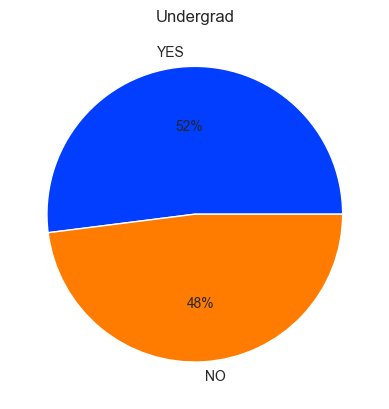

In [712]:
# visualising feature 'Undergrad'
n = data.Undergrad.value_counts()
plt.pie(n.values,labels=n.index,
        colors=sns.color_palette('bright'),
        autopct='%.0f%%')
plt.title('Undergrad')
plt.show()

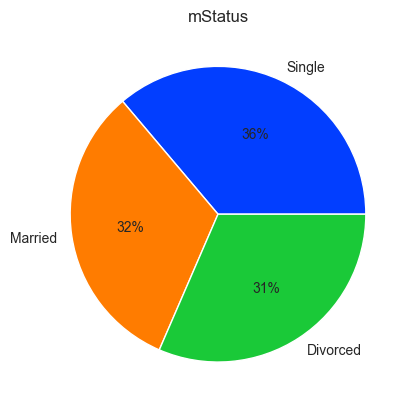

In [713]:
# visualising feature 'marital status'
n = data.mStatus.value_counts()
plt.pie(n.values,labels=n.index,
        colors=sns.color_palette('bright'),
        autopct='%.0f%%')
plt.title('mStatus')
plt.show()

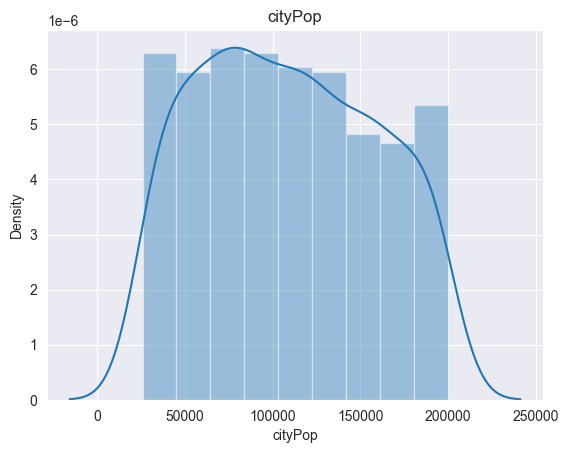

In [714]:
# visualising feature 'city population'
sns.distplot(data.cityPop)
plt.title('cityPop')
plt.show()

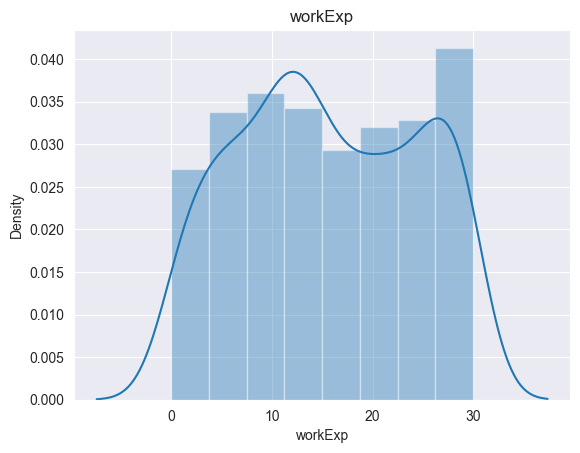

In [715]:
# visualising feature 'work experience'
sns.distplot(data.workExp)
plt.title('workExp')
plt.show()

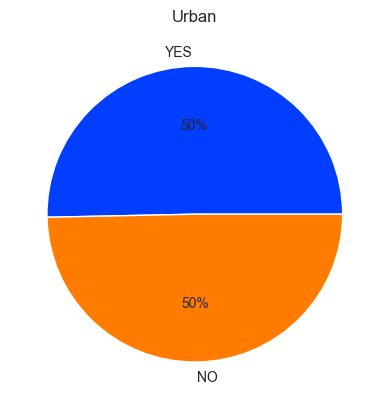

In [716]:
# visualising feature 'urban'
n = data.Urban.value_counts()
plt.pie(n.values,labels=n.index,
        colors=sns.color_palette('bright'),
        autopct='%.0f%%')
plt.title('Urban')
plt.show()

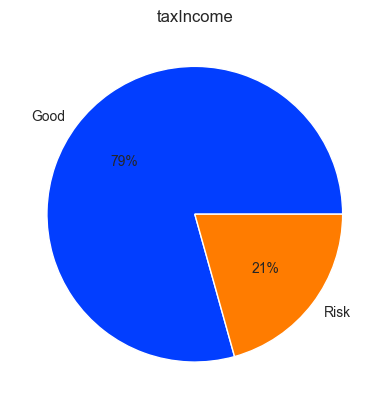

In [717]:
# visualising target 'taxable income'
# target data is imbalanced 
# don't rely on accuracy for model evaluation
n = data.taxIncome.value_counts()
plt.pie(n.values,labels=n.index,
        colors=sns.color_palette('bright'),
        autopct='%.0f%%')
plt.title('taxIncome')
plt.show()

In [718]:
# deepcopy of dataframe 'data'
encData = data.copy(deep=True)
encDict = {}

In [719]:
# label encoding categorical columns 
for col in data.columns[[data[col].dtype == 'object' for col in data.columns]]:
    enc = LabelEncoder()
    encData[col] = enc.fit_transform(data[col])
    encDict[col] = dict(zip(np.arange(enc.classes_.size),enc.classes_))
pprint.pprint(encDict)

{'Undergrad': {0: 'NO', 1: 'YES'},
 'Urban': {0: 'NO', 1: 'YES'},
 'mStatus': {0: 'Divorced', 1: 'Married', 2: 'Single'},
 'taxIncome': {0: 'Good', 1: 'Risk'}}


In [720]:
# label encoded dataframe 
encData.head()

,Undergrad,mStatus,taxIncome,cityPop,workExp,Urban
0,0,2,0,50047,10,1
1,1,0,0,134075,18,1
2,0,1,0,160205,30,1
3,1,2,0,193264,15,1
4,0,1,0,27533,28,0


In [721]:
# segregating data into features and target 'taxIncome'
X = encData.drop(['taxIncome'],axis=1)
Y = encData[['taxIncome']]

In [722]:
# performing oversampling using SMOTE to get balanced target
oversample = SMOTE(random_state=42,sampling_strategy='all',k_neighbors=4)
overX , overY = oversample.fit_resample(X,Y)

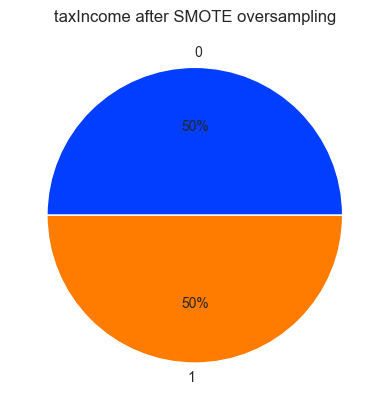

In [723]:
n = overY.taxIncome.value_counts()
plt.pie(n.values,labels=n.index,
        colors=sns.color_palette('bright'),
        autopct='%.0f%%')
plt.title('taxIncome after SMOTE oversampling')
plt.show()

In [724]:
# splitting data for training and testing 
X_train, X_test, Y_train, Y_test = train_test_split(overX,overY,test_size=0.2,
                                                   random_state=42)

In [725]:
# creating basemodel for hyperparameter tunning
baseModel = RandomForestClassifier(random_state=42)
max_depth = [2,6,12]
min_samples_leaf = [2,4,6]
n_estimators = [5,7,9]

param_grid = dict(max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf,
                  n_estimators=n_estimators)
pprint.pprint(param_grid)

{'max_depth': [2, 6, 12],
 'min_samples_leaf': [2, 4, 6],
 'n_estimators': [5, 7, 9]}


In [726]:
# performing hyperparameter tunning with brute force approach 
grid = GridSearchCV(estimator=baseModel,
                    param_grid=param_grid,
                    cv=5,verbose=10,scoring='accuracy')
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START max_depth=2, min_samples_leaf=2, n_estimators=5............
[CV 1/5; 1/27] END max_depth=2, min_samples_leaf=2, n_estimators=5;, score=0.614 total time=   0.0s
[CV 2/5; 1/27] START max_depth=2, min_samples_leaf=2, n_estimators=5............
[CV 2/5; 1/27] END max_depth=2, min_samples_leaf=2, n_estimators=5;, score=0.599 total time=   0.0s
[CV 3/5; 1/27] START max_depth=2, min_samples_leaf=2, n_estimators=5............
[CV 3/5; 1/27] END max_depth=2, min_samples_leaf=2, n_estimators=5;, score=0.651 total time=   0.0s
[CV 4/5; 1/27] START max_depth=2, min_samples_leaf=2, n_estimators=5............
[CV 4/5; 1/27] END max_depth=2, min_samples_leaf=2, n_estimators=5;, score=0.664 total time=   0.0s
[CV 5/5; 1/27] START max_depth=2, min_samples_leaf=2, n_estimators=5............
[CV 5/5; 1/27] END max_depth=2, min_samples_leaf=2, n_estimators=5;, score=0.618 total time=   0.0s
[CV 1/5; 2/27] START max_depth=2,

[CV 5/5; 10/27] END max_depth=6, min_samples_leaf=2, n_estimators=5;, score=0.684 total time=   0.0s
[CV 1/5; 11/27] START max_depth=6, min_samples_leaf=2, n_estimators=7...........
[CV 1/5; 11/27] END max_depth=6, min_samples_leaf=2, n_estimators=7;, score=0.680 total time=   0.0s
[CV 2/5; 11/27] START max_depth=6, min_samples_leaf=2, n_estimators=7...........
[CV 2/5; 11/27] END max_depth=6, min_samples_leaf=2, n_estimators=7;, score=0.691 total time=   0.0s
[CV 3/5; 11/27] START max_depth=6, min_samples_leaf=2, n_estimators=7...........
[CV 3/5; 11/27] END max_depth=6, min_samples_leaf=2, n_estimators=7;, score=0.664 total time=   0.0s
[CV 4/5; 11/27] START max_depth=6, min_samples_leaf=2, n_estimators=7...........
[CV 4/5; 11/27] END max_depth=6, min_samples_leaf=2, n_estimators=7;, score=0.664 total time=   0.0s
[CV 5/5; 11/27] START max_depth=6, min_samples_leaf=2, n_estimators=7...........
[CV 5/5; 11/27] END max_depth=6, min_samples_leaf=2, n_estimators=7;, score=0.651 total ti

[CV 5/5; 21/27] END max_depth=12, min_samples_leaf=2, n_estimators=9;, score=0.717 total time=   0.0s
[CV 1/5; 22/27] START max_depth=12, min_samples_leaf=4, n_estimators=5..........
[CV 1/5; 22/27] END max_depth=12, min_samples_leaf=4, n_estimators=5;, score=0.693 total time=   0.0s
[CV 2/5; 22/27] START max_depth=12, min_samples_leaf=4, n_estimators=5..........
[CV 2/5; 22/27] END max_depth=12, min_samples_leaf=4, n_estimators=5;, score=0.724 total time=   0.0s
[CV 3/5; 22/27] START max_depth=12, min_samples_leaf=4, n_estimators=5..........
[CV 3/5; 22/27] END max_depth=12, min_samples_leaf=4, n_estimators=5;, score=0.678 total time=   0.0s
[CV 4/5; 22/27] START max_depth=12, min_samples_leaf=4, n_estimators=5..........
[CV 4/5; 22/27] END max_depth=12, min_samples_leaf=4, n_estimators=5;, score=0.704 total time=   0.0s
[CV 5/5; 22/27] START max_depth=12, min_samples_leaf=4, n_estimators=5..........
[CV 5/5; 22/27] END max_depth=12, min_samples_leaf=4, n_estimators=5;, score=0.730 to

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 6, 12], 'min_samples_leaf': [2, 4, 6],
                         'n_estimators': [5, 7, 9]},
             scoring='accuracy', verbose=10)

In [727]:
# parameters giving best score 
print(f'Model gives Best Score : {round(grid.best_score_*100,2)}%\nWith params : \nmax_depth : {grid.best_params_["max_depth"]}\nmin_samples_leaf : {grid.best_params_["min_samples_leaf"]}\nn_estimators : {grid.best_params_["n_estimators"]}')

Model gives Best Score : 72.67%
With params : 
max_depth : 12
min_samples_leaf : 2
n_estimators : 9


In [728]:
# Random Forest Classifier with hypertuned parameters 
clf = RandomForestClassifier(n_estimators=9,
                             max_depth=12,
                             min_samples_leaf=2,
                             random_state=42)

In [729]:
# training RandomForestClassifier with hypertuned params 
clf.fit(X_train,Y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=2, n_estimators=9,
                       random_state=42)

In [730]:
print(f'Training Accuracy of final model : {round(clf.score(X_train,Y_train)*100,2)}%')
print(f'Testing Accuracy of final model : {round(clf.score(X_test,Y_test)*100,2)}%')

Training Accuracy of final model : 91.85%
Testing Accuracy of final model : 67.54%


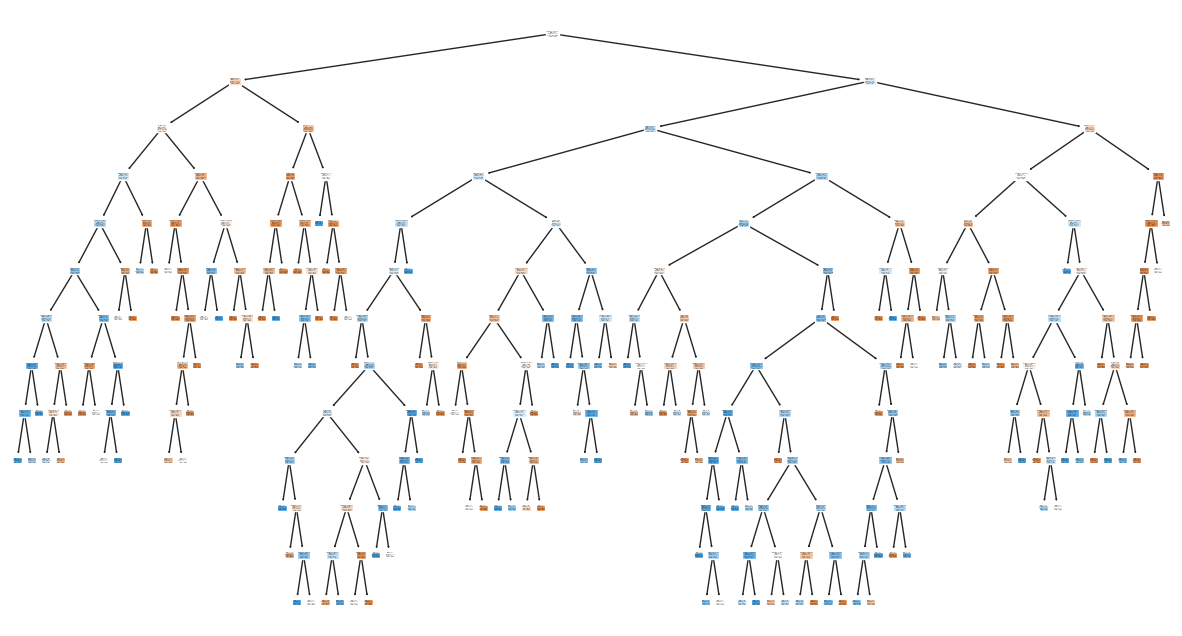

In [731]:
# visualizing trees created by 3 estimators 
# DT by first estimator
plt.figure(figsize=(15,8))
plot_tree(clf.estimators_[0],
          feature_names=X.columns,
          class_names=['High','Low'],
         filled=True)
plt.show()

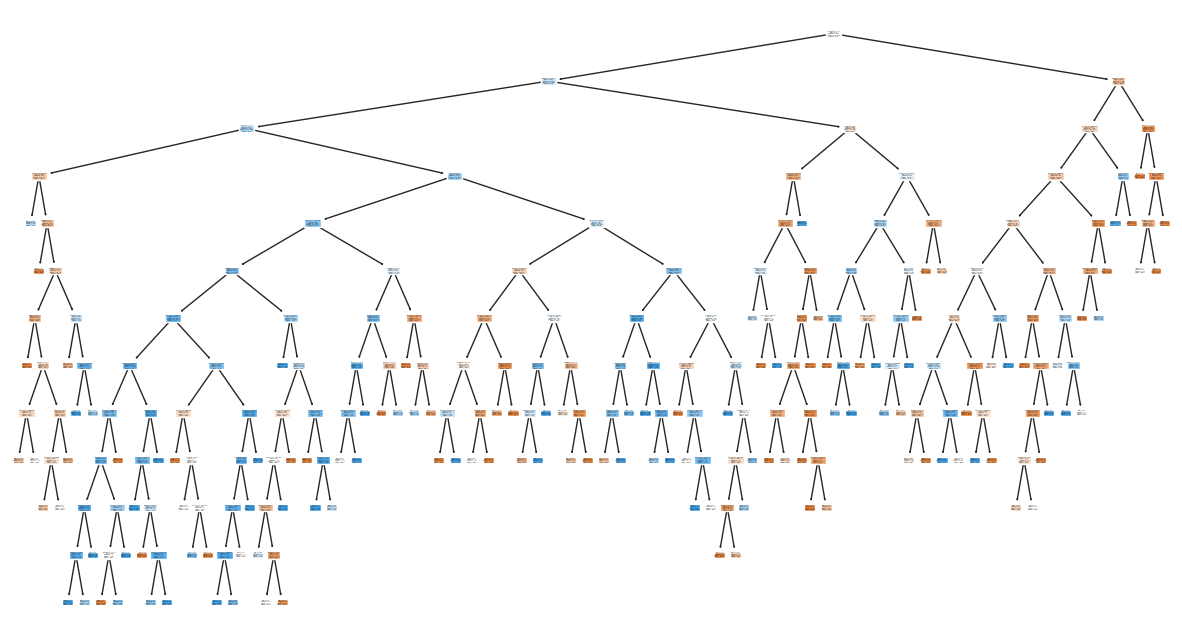

In [732]:
# DT by second estimator
plt.figure(figsize=(15,8))
plot_tree(clf.estimators_[1],
          feature_names=X.columns,
          class_names=['High','Low'],
          filled=True)
plt.show()

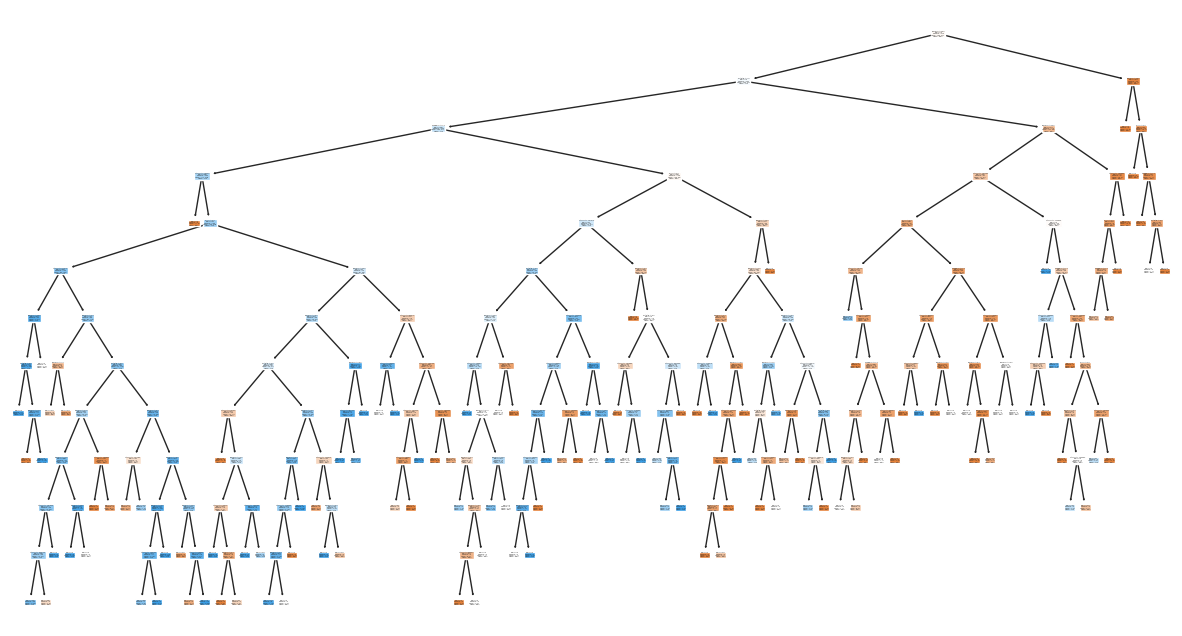

In [733]:
# DT by third estimator 
plt.figure(figsize=(15,8))
plot_tree(clf.estimators_[2],
          feature_names=X.columns,
          class_names=['High','Low'],
          filled=True)
plt.show()

In [734]:
# get important features 
feat_imp = pd.DataFrame(list(zip(X.columns,clf.feature_importances_)),
                        columns=['feature','importance']).sort_values(by='importance',
                                                                     ascending=False)
feat_imp

,feature,importance
2,cityPop,0.461191
3,workExp,0.310363
1,mStatus,0.114013
4,Urban,0.058361
0,Undergrad,0.056072


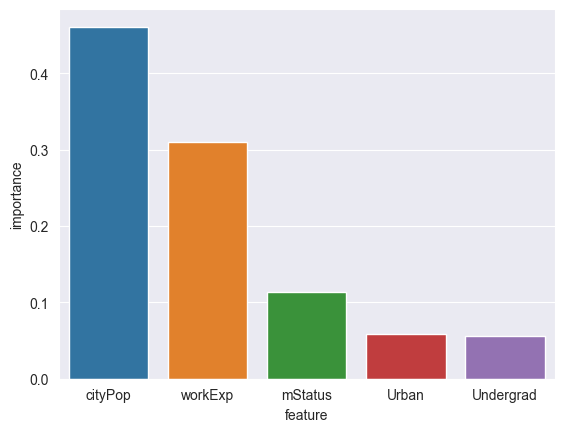

In [735]:
# 'cityPop' is most important feature
# while 'Undergrad' is least important feature
sns.barplot(x='feature',y='importance',
            data=feat_imp)
plt.show()

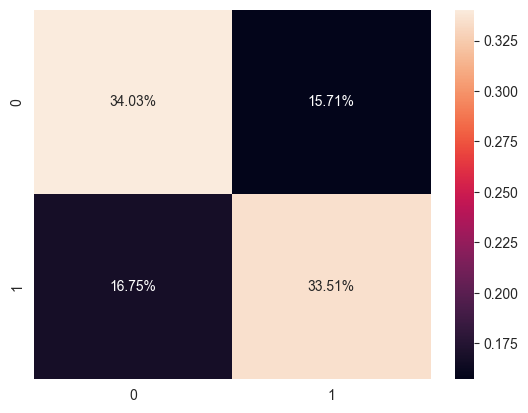

In [736]:
c_matrix = confusion_matrix(Y_test,clf.predict(X_test))
sns.heatmap(c_matrix/c_matrix.sum(),
            annot=True,
            fmt='.2%')
plt.show()

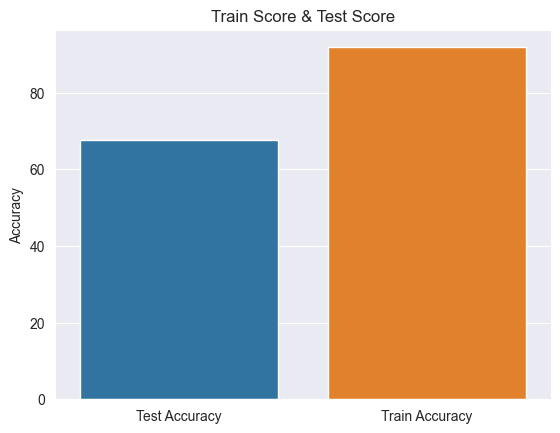

In [737]:
sns.barplot(x=['Test Accuracy','Train Accuracy'],
            y=[round(clf.score(X_test,Y_test)*100,2),
               round(clf.score(X_train,Y_train)*100,2)])
plt.ylabel('Accuracy')
plt.title('Train Score & Test Score')
plt.show()

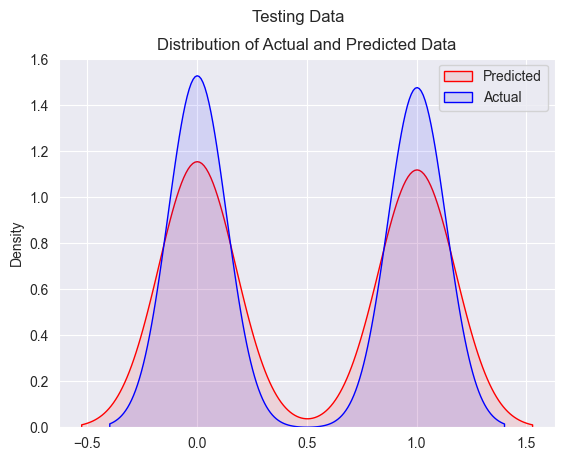

In [738]:
sns.distplot(clf.predict(X_test),hist=False,color='red',
             kde_kws={'shade':True,'alpha':0.1})
sns.distplot(clf.predict(X_train),hist=False,color='blue',
             kde_kws={'shade':True,'alpha':0.1})
plt.legend(['Predicted','Actual'],loc='upper right')
plt.title('Distribution of Actual and Predicted Data')
plt.suptitle('Testing Data')
plt.show()

In [739]:
# model gives 68% testing f1 score
print(classification_report(Y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68        95
           1       0.68      0.67      0.67        96

    accuracy                           0.68       191
   macro avg       0.68      0.68      0.68       191
weighted avg       0.68      0.68      0.68       191



In [740]:
# prediction on test data
pred = X_test.reset_index(drop='index').join(pd.DataFrame(clf.predict(X_test),
                                                    columns=['Fraud Assesment']))
pred['Fraud Assesment'] = pred['Fraud Assesment'].replace(encDict['taxIncome'])
pred

,Undergrad,mStatus,cityPop,workExp,Urban,Fraud Assesment
0,1,1,145744,9,1,Good
1,0,0,84473,2,0,Risk
2,0,2,103910,27,0,Good
3,0,0,181838,1,0,Risk
4,1,2,101272,24,1,Good
...,...,...,...,...,...,...
186,1,2,157251,21,0,Good
187,0,0,147414,21,0,Risk
188,1,1,161492,9,0,Risk
189,1,2,197916,7,0,Risk


## RandomForestClassifier on Fraud data with training accuracy of 91.85% and testing accuracy of 67.54%